In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [2]:
sourceFile = open("gpu_logs/coopernico_97.txt", 'w')

### Load the data

In [3]:
df = pd.read_csv("data/coopernico_50houses_location.csv")
## Leaving the first house (public building out) due to its different profile
df = df.iloc[:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
num_samples_per_house = df.Location.value_counts()[1]
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2021-11-01 00:15:00,PT84ZD,0.144
1,2021-11-01 00:30:00,PT84ZD,0.144
2,2021-11-01 00:45:00,PT84ZD,0.144
3,2021-11-01 01:00:00,PT84ZD,0.144
4,2021-11-01 01:15:00,PT84ZD,0.028
...,...,...,...
1138131,2023-02-28 23:00:00,PT37FP,0.000
1138132,2023-02-28 23:15:00,PT37FP,1.000
1138133,2023-02-28 23:30:00,PT37FP,0.000
1138134,2023-02-28 23:45:00,PT37FP,1.000


In [4]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [5]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [6]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)

def past_timesteps(df, number_of_timesteps):
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

#def past_timesteps(df, number_of_timesteps):
#    # Sort the dataframe by location and time
#    df = df.sort_values(by=['Location', 'Time'])
#
#    # Compute rolling window over time axis to extract past energy values for each location
#    energy_lags = [f"energy_lag_{i}" for i in range(1, number_of_timesteps+1)]
#    past_energy = df.groupby('Location')['Energy'].rolling(window=number_of_timesteps, min_periods=1).apply(np.mean())
#    # Add new columns to the dataframe for each past energy value
#    for i, energy_lag in enumerate(energy_lags):
#        df[energy_lag] = past_energy.apply(lambda x: x[-i-1] if isinstance(x, list) and len(x)>=i+1 else x)
#
#    # Drop rows with missing values
#    df.dropna(inplace=True)
#    df.reset_index(drop=True, inplace=True)
#
#    return df


def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe
    

In [7]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [8]:
def test_leave_house_out(df, estimator, locations, filename):
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)
    #y_train_norm, scaler2 = normalize_training(y_train)
    #y_test_norm = scaler2.transform(y_test)
    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Save Dataframe with past timesteps

In [ ]:
number_of_timesteps = 97

In [ ]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

In [ ]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

In [ ]:
df_new.to_csv("data/coopernico_oneday.csv", index=False)

## Predict  10 folds with 10 random houses for test

In [9]:
df = pd.read_csv("data/coopernico_oneday.csv")
df

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_91,energy_lag_92,energy_lag_93,energy_lag_94,energy_lag_95,energy_lag_96,energy_lag_97,DayOfWeek,Weekend,Hour
0,2021-11-02 00:30:00,PT01NZ,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,...,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1,0,0
1,2021-11-02 00:45:00,PT01NZ,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,...,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1,0,0
2,2021-11-02 01:00:00,PT01NZ,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,...,0.000,1.000,0.000,0.000,1.000,0.000,1.000,1,0,1
3,2021-11-02 01:15:00,PT01NZ,1.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,...,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1,0,1
4,2021-11-02 01:30:00,PT01NZ,0.000,1.000,1.000,0.000,1.000,0.000,1.000,0.000,...,1.000,1.000,0.000,1.000,0.000,0.000,1.000,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091882,2022-10-31 23:00:00,PT92QP,0.020,0.016,0.020,0.020,0.020,0.020,0.016,0.020,...,0.020,0.016,0.020,0.020,0.016,0.020,0.020,0,0,23
1091883,2022-10-31 23:15:00,PT92QP,0.020,0.020,0.016,0.020,0.020,0.020,0.020,0.016,...,0.020,0.020,0.016,0.020,0.020,0.016,0.020,0,0,23
1091884,2022-10-31 23:30:00,PT92QP,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0.020,...,0.020,0.020,0.020,0.016,0.020,0.020,0.016,0,0,23
1091885,2022-10-31 23:45:00,PT92QP,0.016,0.020,0.020,0.020,0.016,0.020,0.020,0.020,...,0.016,0.020,0.020,0.020,0.016,0.020,0.020,0,0,23


In [10]:
df.isna().sum().sum()

0

In [11]:
num_houses_test = 10

In [12]:
locations = []
for i in range(10):
    np.random.seed(i*4)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['PT61DK', 'PT31GJ', 'PT28AS', 'PT75MV', 'PT16CG', 'PT58SX',
        'PT73RB', 'PT64BZ', 'PT51YP', 'PT24EC'], dtype=object),
 array(['PT25VW', 'PT92KV', 'PT31GJ', 'PT24EC', 'PT33DY', 'PT64BZ',
        'PT26AT', 'PT58FW', 'PT75MV', 'PT43EA'], dtype=object),
 array(['PT84ZD', 'PT92QP', 'PT72LM', 'PT53VD', 'PT92KV', 'PT51YP',
        'PT65SJ', 'PT01NZ', 'PT43AE', 'PT86XC'], dtype=object),
 array(['PT61DK', 'PT87CQ', 'PT26AT', 'PT75MV', 'PT72LM', 'PT61WB',
        'PT47FA', 'PT92KV', 'PT44HY', 'PT26CA'], dtype=object),
 array(['PT22FE', 'PT66PT', 'PT58FW', 'PT72LM', 'PT46LV', 'PT53VD',
        'PT67FS', 'PT47FA', 'PT74TE', 'PT74PR'], dtype=object),
 array(['PT33DY', 'PT37FP', 'PT24EC', 'PT26CA', 'PT86XC', 'PT14YZ',
        'PT58FW', 'PT54MR', 'PT91LB', 'PT53VD'], dtype=object),
 array(['PT26CA', 'PT24FF', 'PT64MJ', 'PT58JM', 'PT44HY', 'PT16CG',
        'PT42TA', 'PT74TE', 'PT61WB', 'PT72VJ'], dtype=object),
 array(['PT31GJ', 'PT42TA', 'PT26MC', 'PT64BZ', 'PT58SX', 'PT46LV',
        

### Linear Regression

In [13]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

Train set:  (901393, 103)
Test set:  (190494, 103)
Train set:  (890324, 103)
Test set:  (201563, 103)
Train set:  (821413, 103)
Test set:  (270474, 103)
Train set:  (892334, 103)
Test set:  (199553, 103)
Train set:  (867128, 103)
Test set:  (224759, 103)
Train set:  (879385, 103)
Test set:  (212502, 103)
Train set:  (939184, 103)
Test set:  (152703, 103)
Train set:  (860407, 103)
Test set:  (231480, 103)
Train set:  (875735, 103)
Test set:  (216152, 103)
Train set:  (925847, 103)
Test set:  (166040, 103)


### XGBoost

In [14]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

Train set:  (901393, 103)
Test set:  (190494, 103)
Train set:  (890324, 103)
Test set:  (201563, 103)
Train set:  (821413, 103)
Test set:  (270474, 103)
Train set:  (892334, 103)
Test set:  (199553, 103)
Train set:  (867128, 103)
Test set:  (224759, 103)
Train set:  (879385, 103)
Test set:  (212502, 103)
Train set:  (939184, 103)
Test set:  (152703, 103)
Train set:  (860407, 103)
Test set:  (231480, 103)
Train set:  (875735, 103)
Test set:  (216152, 103)
Train set:  (925847, 103)
Test set:  (166040, 103)


### Random Forest

In [15]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

Train set:  (901393, 103)
Test set:  (190494, 103)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (890324, 103)
Test set:  (201563, 103)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (821413, 103)
Test set:  (270474, 103)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (892334, 103)
Test set:  (199553, 103)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (867128, 103)
Test set:  (224759, 103)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (879385, 103)
Test set:  (212502, 103)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (939184, 103)
Test set:  (152703, 103)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (860407, 103)
Test set:  (231480, 103)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (875735, 103)
Test set:  (216152, 103)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (925847, 103)
Test set:  (166040, 103)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [16]:
print("\n\n\n", file=sourceFile)

In [17]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [18]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [19]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

In [20]:
sourceFile.close()

### Feature Importance

In [21]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

Linear Regression

Feature: 0, Score: 183.20952
Feature: 1, Score: -55.81589
Feature: 2, Score: 19.29249
Feature: 3, Score: -7.52286
Feature: 4, Score: 1.51816
Feature: 5, Score: -3.57059
Feature: 6, Score: 1.19053
Feature: 7, Score: -0.56572
Feature: 8, Score: -1.23842
Feature: 9, Score: -1.87243
Feature: 10, Score: -0.90426
Feature: 11, Score: -0.37028
Feature: 12, Score: 0.65043
Feature: 13, Score: 3.10116
Feature: 14, Score: 1.16981
Feature: 15, Score: -0.14114
Feature: 16, Score: -1.76898
Feature: 17, Score: 1.34725
Feature: 18, Score: -0.79026
Feature: 19, Score: 0.54345
Feature: 20, Score: 2.09132
Feature: 21, Score: -1.56939
Feature: 22, Score: -0.52339
Feature: 23, Score: -0.91595
Feature: 24, Score: -0.00678
Feature: 25, Score: 0.02585
Feature: 26, Score: 0.06579
Feature: 27, Score: -0.39483
Feature: 28, Score: 1.48521
Feature: 29, Score: -0.55692
Feature: 30, Score: 0.90643
Feature: 31, Score: -0.87693
Feature: 32, Score: 0.55343
Feature: 33, Score: -0.93057
Feature: 34, Sco

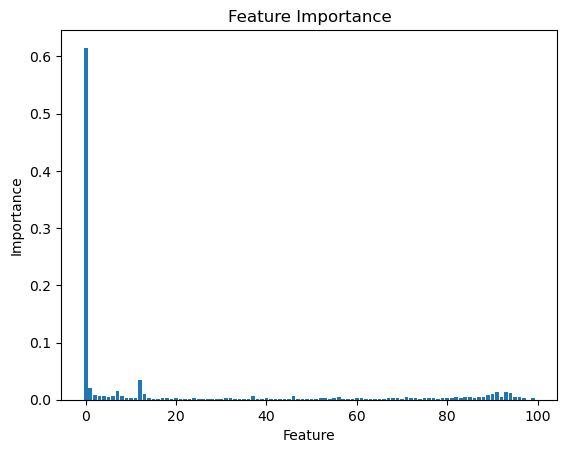

In [22]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

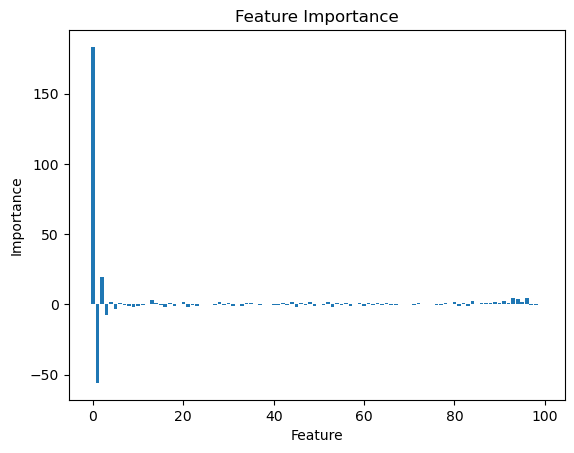

In [23]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [24]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

energy_lag_1     0.615264
energy_lag_2     0.020035
energy_lag_3     0.007395
energy_lag_4     0.006874
energy_lag_5     0.005733
                   ...   
energy_lag_96    0.005581
energy_lag_97    0.003953
DayOfWeek        0.002175
Weekend          0.000000
Hour             0.003843
Length: 100, dtype: float32

In [25]:
features = feature_importance.nlargest(40).index
features

Index(['energy_lag_1', 'energy_lag_13', 'energy_lag_2', 'energy_lag_8',
       'energy_lag_94', 'energy_lag_92', 'energy_lag_95', 'energy_lag_91',
       'energy_lag_14', 'energy_lag_90', 'energy_lag_3', 'energy_lag_4',
       'energy_lag_47', 'energy_lag_9', 'energy_lag_7', 'energy_lag_5',
       'energy_lag_38', 'energy_lag_96', 'energy_lag_93', 'energy_lag_88',
       'energy_lag_86', 'energy_lag_89', 'energy_lag_6', 'energy_lag_57',
       'energy_lag_83', 'energy_lag_85', 'energy_lag_72', 'energy_lag_97',
       'Hour', 'energy_lag_15', 'energy_lag_19', 'energy_lag_11',
       'energy_lag_81', 'energy_lag_82', 'energy_lag_41', 'energy_lag_21',
       'energy_lag_68', 'energy_lag_54', 'energy_lag_12', 'energy_lag_77'],
      dtype='object')

In [26]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

,Time,Location,energy_lag_1,energy_lag_13,energy_lag_2,energy_lag_8,energy_lag_94,energy_lag_92,energy_lag_95,energy_lag_91,...,energy_lag_11,energy_lag_81,energy_lag_82,energy_lag_41,energy_lag_21,energy_lag_68,energy_lag_54,energy_lag_12,energy_lag_77,Energy
0,2021-11-02 00:30:00,PT01NZ,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,...,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000
1,2021-11-02 00:45:00,PT01NZ,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,...,1.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
2,2021-11-02 01:00:00,PT01NZ,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,...,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000
3,2021-11-02 01:15:00,PT01NZ,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000
4,2021-11-02 01:30:00,PT01NZ,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,...,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091882,2022-10-31 23:00:00,PT92QP,0.016,0.016,0.020,0.020,0.020,0.016,0.016,0.020,...,0.020,0.020,0.020,0.172,0.016,0.020,0.136,0.020,0.016,0.020
1091883,2022-10-31 23:15:00,PT92QP,0.020,0.020,0.016,0.020,0.020,0.020,0.020,0.020,...,0.020,0.016,0.020,0.172,0.020,0.020,0.140,0.020,0.020,0.020
1091884,2022-10-31 23:30:00,PT92QP,0.020,0.020,0.020,0.016,0.016,0.020,0.020,0.020,...,0.016,0.020,0.016,0.152,0.020,0.016,0.156,0.020,0.020,0.020
1091885,2022-10-31 23:45:00,PT92QP,0.020,0.020,0.020,0.020,0.020,0.020,0.016,0.016,...,0.020,0.020,0.020,0.144,0.020,0.020,0.160,0.016,0.020,0.016


In [27]:
df_40.to_csv("data/coopernico_best40features_oneday.csv", index=False)

### Test with 40 best features

In [28]:
df_40 = pd.read_csv("data/coopernico_best40features_oneday.csv")
df_40

,Time,Location,energy_lag_1,energy_lag_13,energy_lag_2,energy_lag_8,energy_lag_94,energy_lag_92,energy_lag_95,energy_lag_91,...,energy_lag_11,energy_lag_81,energy_lag_82,energy_lag_41,energy_lag_21,energy_lag_68,energy_lag_54,energy_lag_12,energy_lag_77,Energy
0,2021-11-02 00:30:00,PT01NZ,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,...,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000
1,2021-11-02 00:45:00,PT01NZ,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,...,1.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
2,2021-11-02 01:00:00,PT01NZ,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,...,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000
3,2021-11-02 01:15:00,PT01NZ,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000
4,2021-11-02 01:30:00,PT01NZ,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,...,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091882,2022-10-31 23:00:00,PT92QP,0.016,0.016,0.020,0.020,0.020,0.016,0.016,0.020,...,0.020,0.020,0.020,0.172,0.016,0.020,0.136,0.020,0.016,0.020
1091883,2022-10-31 23:15:00,PT92QP,0.020,0.020,0.016,0.020,0.020,0.020,0.020,0.020,...,0.020,0.016,0.020,0.172,0.020,0.020,0.140,0.020,0.020,0.020
1091884,2022-10-31 23:30:00,PT92QP,0.020,0.020,0.020,0.016,0.016,0.020,0.020,0.020,...,0.016,0.020,0.016,0.152,0.020,0.016,0.156,0.020,0.020,0.020
1091885,2022-10-31 23:45:00,PT92QP,0.020,0.020,0.020,0.020,0.020,0.020,0.016,0.016,...,0.020,0.020,0.020,0.144,0.020,0.020,0.160,0.016,0.020,0.016


In [29]:
sourceFile = open("gpu_logs/coopernico_97_40best.txt", 'w')

In [30]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df_40, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

Train set:  (901393, 43)
Test set:  (190494, 43)
Train set:  (890324, 43)
Test set:  (201563, 43)
Train set:  (821413, 43)
Test set:  (270474, 43)
Train set:  (892334, 43)
Test set:  (199553, 43)
Train set:  (867128, 43)
Test set:  (224759, 43)
Train set:  (879385, 43)
Test set:  (212502, 43)
Train set:  (939184, 43)
Test set:  (152703, 43)
Train set:  (860407, 43)
Test set:  (231480, 43)
Train set:  (875735, 43)
Test set:  (216152, 43)
Train set:  (925847, 43)
Test set:  (166040, 43)


In [31]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df_40, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

Train set:  (901393, 43)
Test set:  (190494, 43)
Train set:  (890324, 43)
Test set:  (201563, 43)
Train set:  (821413, 43)
Test set:  (270474, 43)
Train set:  (892334, 43)
Test set:  (199553, 43)
Train set:  (867128, 43)
Test set:  (224759, 43)
Train set:  (879385, 43)
Test set:  (212502, 43)
Train set:  (939184, 43)
Test set:  (152703, 43)
Train set:  (860407, 43)
Test set:  (231480, 43)
Train set:  (875735, 43)
Test set:  (216152, 43)
Train set:  (925847, 43)
Test set:  (166040, 43)


In [38]:
df_40.iloc[:,1]

0          PT01NZ
1          PT01NZ
2          PT01NZ
3          PT01NZ
4          PT01NZ
            ...  
1091882    PT92QP
1091883    PT92QP
1091884    PT92QP
1091885    PT92QP
1091886    PT92QP
Name: Location, Length: 1091887, dtype: object

In [32]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df_40, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

Train set:  (901393, 43)
Test set:  (190494, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (890324, 43)
Test set:  (201563, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (821413, 43)
Test set:  (270474, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (892334, 43)
Test set:  (199553, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (867128, 43)
Test set:  (224759, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (879385, 43)
Test set:  (212502, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (939184, 43)
Test set:  (152703, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (860407, 43)
Test set:  (231480, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (875735, 43)
Test set:  (216152, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (925847, 43)
Test set:  (166040, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [33]:
print("\n\n\n", file=sourceFile)

In [34]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [35]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [36]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

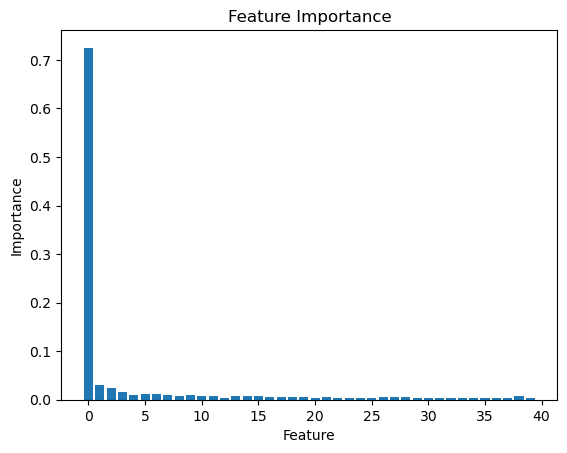

In [37]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()